In [1]:
import json, os
import pickle
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 设置随机种子保证可复现
import random
SEED = 729608
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# os python hash seed, make experiment reproducable
os.environ['PYTHONHASHSEED'] = str(SEED)
# gpu algorithom 
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Generator SEED
Generator = torch.Generator()
Generator.manual_seed(SEED)

/home/charon/anaconda3/envs/qbw_base/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 数据来源文件夹 -- 内含多个json文件
non_rumor = './Chinese_Rumor_Dataset/CED_Dataset/non-rumor-repost'
rumor = './Chinese_Rumor_Dataset/CED_Dataset/rumor-repost'
original = './Chinese_Rumor_Dataset/CED_Dataset/original-microblog'

non_rumor_data = []
rumor_data = []

# 遍历文件夹，读取文本数据
print('开始读取数据')
for file in tqdm(os.listdir(original)):
    try:
        data = json.load(open(os.path.join(original, file), 'rb'))['text']
    except:
        continue

    is_rumor = (file in os.listdir(rumor))
    if is_rumor:
        rumor_data.append(data)
    else:
        non_rumor_data.append(data)

print('结束, 有{}条谣言, 有{}条非谣言!'.format(len(rumor_data), len(non_rumor_data)))
print(non_rumor_data[-2:])
print('-'*20)
print(rumor_data[-2:])


# 把数据储存到指定地方 -- 统一到2个txt文件
pth = './rumor_detection_data'
if not os.path.exists(pth):
    os.makedirs(pth)

good_file = os.path.join(pth, 'non_rumor.txt')
bad_file = os.path.join(pth, 'rumor.txt')

# with open(good_file, 'w', encoding='utf-8') as f:
#     f.write('\n'.join(non_rumor_data))
# with open(bad_file, 'w', encoding='utf-8') as f:
#     f.write('\n'.join(rumor_data))

开始读取数据


100%|██████████| 3389/3389 [00:01<00:00, 2140.89it/s]

结束, 有1538条谣言, 有1849条非谣言!
['＂有时最坚强的人是 - 不因缺陷而不爱，关起门才哭泣，和打没有人知道的仗。＂(Sometimes the strongest people are the one love beyond all faults, cry behind closed doors and fight battles that nobody knows about。)', '想研究外星人么？ 去爱大吧！！ 爱丁堡大学计划今年年底第一次提供寻找外星人的课程。。"Introduction to Astrobiology and the Search for Extraterrestrial Life" 将由学校的星际生物学教授Charles Cockell 讲授！']
--------------------
['【#越南乳瓜#】神奇的越南乳瓜，神似女性的乳房，颜色略呈粉色。乳瓜成熟果实含葡萄糖、果糖、蔗糖、胡萝卜素、维生素C、酒石酸、枸椽酸、苹果酸等。未成熟果实的汁液中含多量的乳瓜蛋白酶、脂肪酶。营养价值也很高。可是这样的瓜你敢吃吗。#我心中的乳神# \u200b', '【阿婆厕所捡婴儿 被计生干部查获后活活摔死】15日下午，刘阿婆从乡财政所厕所粪便中将孩子捞起，简单清洗，剪脐带打针消毒。处理妥当正给孩子喂水时，武汉黄陂区蔡店乡计生办5人出现，夺走孩子掼在地上，用脚踢，放稻田里淹。引起当地群众的公愤。 @上海派對SHClubbing']


In [3]:
# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？?、~@#￥%……&*（）：:；“”】》《-【\][]", "",sentence.strip())
    return sentence

# 扫描所有的文本，分词、建立词典，分出是谣言还是非谣言，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(good_file, bad_file, is_filter = True, threshold=3):
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储非谣言
    neg_sentences = [] #存储谣言
    with open(good_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
                if not idx: # 只打印第一个例子看看
                    print('分词前：', line)
            #分词
            words = jieba.lcut(line)
            if not idx: # 只打印第一个例子看看
                print('分词后：', words)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line.strip())
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，只保留频次大于threshold的单词
    vocab = {'<unk>': 0}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        if freq > threshold:
            vocab[word] = len(vocab)
        
    print('过滤掉词频 <= {}的单词后，字典大小：{}'.format(threshold, len(vocab)))
    return pos_sentences, neg_sentences, vocab


pos_sentences, neg_sentences, vocab = Prepare_data(good_file, bad_file, True, threshold=3)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


分词前： 最值得爱一生的五大星座排名第一名巨蟹座不畏艰辛患难与共第二名金牛座不离不弃第三名处女座不逃避困难第四名魔羯座一起吃苦第五名天蝎座真情守护被巨蟹座爱上是需要几世才能修来的好福气啊


Loading model cost 0.368 seconds.
Prefix dict has been built successfully.


分词后： ['最', '值得', '爱', '一生', '的', '五大', '星座', '排名', '第一名', '巨蟹座', '不畏', '艰辛', '患难与共', '第二名', '金牛座', '不离', '不弃', '第三名', '处女座', '不', '逃避', '困难', '第四名', '魔羯座', '一起', '吃苦', '第五名', '天蝎座', '真情', '守护', '被', '巨蟹座', '爱上', '是', '需要', '几世', '才能', '修来', '的', '好福气', '啊']
./rumor_detection_data/non_rumor.txt 包含 1849 行, 92943 个词.
./rumor_detection_data/rumor.txt 包含 1538 行, 78645 个词.
过滤掉词频 <= 3的单词后，字典大小：6690


In [4]:
# 获得句子的向量化表示
def sentence2vec(word_ids, vocab_size):
    vector = np.zeros(vocab_size)
    for word_id in word_ids:
        vector[word_id] += 1 # 统计词频，得到词频向量即为句子的向量化表示
    return 1.0 * vector / len(word_ids)

bow = [] #词袋
labels = [] #标签
sentences = [] #原始句子，调试用
sentences_id = [] #原始句子对应的index列表

# 处理非谣言
for sentence in pos_sentences:
    new_sentence = []
    for word in sentence:
        new_sentence.append(vocab[word] if word in vocab else vocab['<unk>'])
    
    bow.append(sentence2vec(new_sentence, len(vocab)))
    labels.append(0) #正标签为0 表示非谣言数据
    sentences.append(sentence)
    sentences_id.append(new_sentence)

# 处理谣言
for sentence in neg_sentences:
    new_sentence = []
    for word in sentence:
        new_sentence.append(vocab[word] if word in vocab else vocab['<unk>'])

    bow.append(sentence2vec(new_sentence, len(vocab)))
    labels.append(1) #负标签为1
    sentences.append(sentence)
    sentences_id.append(new_sentence)

# 打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(bow))

#对整个数据集进行划分，分为：训练集、验证集和测试集，这里是2:1:1
test_size = len(bow) // 4

data = {
    'bow': bow,# 词袋数据
    'labels': labels,# 标签
    'sentences_id': sentences_id,# 句子对应的word下标列表
    'sentences': sentences,# 句子
    'vocab': vocab # 词典,
}
split = {
    'train': indices[2*test_size:],
    'vali': indices[:test_size],
    'test': indices[test_size:2*test_size]
}

In [5]:
# 测试一下划分情况
while True:
    tag = True
    for key, indices in split.items():
        count = [0, 0]
        for idx in indices:
            count[labels[idx]] += 1
        # 如果类别过于不平衡，则重新随机化
        cls_ratio = count[0]/count[1]
        ratio_threshold = 1.5
        if cls_ratio > ratio_threshold or cls_ratio < 1/ratio_threshold:
            indices = np.random.permutation(len(bow))
            tag = False
            break
        print(key, '非谣言有{}条，谣言有{}条'.format(count[0], count[1]))
        if key==2:
            tag = True
    if tag:
        break

train 非谣言有938条，谣言有757条
vali 非谣言有478条，谣言有368条
test 非谣言有433条，谣言有413条


In [6]:
class AverageMeter(object):
    """
    用于储存与计算平均值
    """ 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1, multiply=True):
        self.val = val
        if multiply:
            self.sum += val * n
        else:
            self.sum += val
        self.count += n
        self.avg = self.sum / self.count

def training(model, loader, crit, optim, device):
    # 模型调成训练模式
    model.train()
    # 把模型移到指定设备
    model.to(device)
    # 用于记录损失和正确率
    meter_loss, meter_acc = AverageMeter(), AverageMeter()
    
    for data in loader:
        # 清空梯度
        optim.zero_grad()
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        # 计算损失
        loss = crit(outputs, labels)
        # 反向传播，计算梯度
        loss.backward()
        # 更新网络参数
        optim.step()
        
        # 记录损失
        num_sample = inputs.size(0)
        meter_loss.update(loss.item(), num_sample)
        # 记录预测正确率
        preds = outputs.max(dim=1)[1] # 网络预测的类别结果
        correct = (preds == labels).sum() # 计算预测的正确个数
        meter_acc.update(correct.item(), num_sample, multiply=False)
    
    # 返回训练集的平均损失和平均正确率
    return meter_loss.avg, meter_acc.avg

@torch.no_grad()
def evaluate(model, loader, crit, device):
    # 模型调成评估模式
    model.eval()
    # 把模型移到指定设备
    model.to(device)
    # 用于记录损失和正确率
    meter_loss, meter_acc = AverageMeter(), AverageMeter()
    for data in loader:
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        
        # 计算并记录损失
        loss = crit(outputs, labels)
        num_sample = inputs.size(0)
        meter_loss.update(loss.item(), num_sample)
        # 记录预测正确率
        preds = outputs.max(dim=1)[1] # 网络预测的类别结果
        correct = (preds == labels).sum() # 计算预测的正确个数
        meter_acc.update(correct.item(), num_sample, multiply=False)

    return meter_loss.avg, meter_acc.avg

In [7]:
class BaseDataset(Dataset): # BOW化的sentence无需指定数据的max_len，因为已经确定len是词表大小
    def __init__(self, data, split):
        super().__init__()
        self.make_dataset(data, split)

    def make_dataset(self, data, split):
        # Data是包含了整个数据集的数据
        # 而我们只需要训练集/验证集/测试集的数据
        # 我们按照划分基准split里面的下标来确定加载哪部分的数据
        self.dataset = []
        for idx in split:
            item = [torch.FloatTensor(data['bow'][idx]), 
                    torch.LongTensor([data['labels'][idx]])] # 做CELoss需要label是long类型
            self.dataset.append(item)

    def __getitem__(self, ix):
        # ix大于等于0，小于len(self.dataset)
        return self.dataset[ix]
    
    def __len__(self):
        # 一共有多少数据
        return len(self.dataset)


def get_loader(data, split, batch_size=64, class_func=BaseDataset):
    # split.keys() 包括 'train', 'vali', 'test'
    # 所以此函数是为了拿到训练集，验证集和测试集的数据加载器
    loader = []
    for mode in split.keys():
        # split[mode]指定了要取data的哪些数据
        dataset = class_func(data, split[mode])
        # Dataloader可帮助我们一次性取batch_size个样本出来
        loader.append(
            DataLoader(dataset,
                       batch_size = batch_size,
                       shuffle = True if mode=='train' else False)
        )
    return loader

In [8]:
# 测试一下
_, _, fake_loader = get_loader(data, split, 64)
x, y = next(iter(fake_loader))
print('词袋输入的形状：', x.shape)
print('标签的形状：', y.shape)

词袋输入的形状： torch.Size([64, 6690])
标签的形状： torch.Size([64, 1])


In [9]:
word2vec_dir = '/media/charon/ubuntu_data/cn_pretrained_model'
file_lst = os.listdir(word2vec_dir)
filtered_file_lst = [file for file in file_lst if Path(file).suffix != '.py']
word2vec_param_lst = []
for filename in filtered_file_lst:
    count = 0
    with open(os.path.join(word2vec_dir,filename),'r') as f:
        for idx,line in enumerate(f):
            if not idx:
                num_words,num_embed = [int(e) for e in line.split(' ')]
                word2vec_param = torch.randn((len(vocab),num_embed),dtype=torch.float32)
                continue

            l = line.split(' ')
            word,vec = l[0],[float(e) for e in l[1:-1]]
            if word in vocab.keys():
                idx = vocab[word]
                word2vec_param[idx,:] = torch.tensor(vec,dtype=torch.float32)
                count += 1
    print(f'pretrained model filename {filename}')
    print('num of words not in the pre-training corpus : ',len(vocab)-count)
    print('num of words in the pre-training corpus : ',count)
    word2vec_param_lst.append(word2vec_param)

pretrained model filename sgns.merge.word
num of words not in the pre-training corpus :  477
num of words in the pre-training corpus :  6213
pretrained model filename sgns.sogou.word
num of words not in the pre-training corpus :  591
num of words in the pre-training corpus :  6099
pretrained model filename sgns.target.word-word.dynwin5.thr10.neg5.dim300.iter5
num of words not in the pre-training corpus :  530
num of words in the pre-training corpus :  6160
pretrained model filename sgns.weibo.word
num of words not in the pre-training corpus :  581
num of words in the pre-training corpus :  6109


In [10]:
class Word2Vec_Cls(nn.Module):
    def __init__(self,vocab_size,pad_index,dropout,word2vec_param):
        super().__init__()
        vec_size = word2vec_param.shape[1]
        self.word_embs = nn.Embedding(vocab_size,vec_size)
        self.mlp = nn.Sequential(
            nn.LayerNorm(vec_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(vec_size,2)
        )
        self.pad_index = pad_index
        self.GAP = nn.AdaptiveAvgPool1d(1)
        self.word_embs.weight.data[:-1,:] = word2vec_param
        self.word_embs.weight.data[-1:-2,:] = torch.zeros((1,vec_size),dtype=torch.float32)

    def forward(self,x,log_softmax=True):
        bs = x.shape[0]
        embed = self.word_embs(x)
        cls = self.GAP(self.mlp(embed).permute(0,2,1).contiguous()).view(bs,2)
        if log_softmax:
            cls = F.log_softmax(cls,dim=1)
        return cls

In [11]:
class MyDataset(Dataset): # Transformer的输入句子的表示形式会不定长，要矩阵化存储需要指定一个max_len，不到的去做padding，超过的做truncationœ
    def __init__(self, data, split):
        super().__init__()
        self.vocab = data['vocab']
        self.pad_index = len(self.vocab.keys()) if '<pad>' not in self.vocab.keys() else self.vocab['<pad>']
        self.max_len = data.get('max_len', 30)
        self.make_dataset(data, split)

    def make_dataset(self, data, split):
        # Data是包含了整个数据集的数据
        # 而我们只需要训练集/验证集/测试集的数据
        # 我们按照划分基准split里面的下标来确定加载哪部分的数据
        self.dataset = []
        for idx in split:
            this_sentence_id = data['sentences_id'][idx]
            item = [
                torch.LongTensor(self.pad_data(this_sentence_id)),
                torch.LongTensor([data['labels'][idx]])
            ]
            self.dataset.append(item)

    def pad_data(self, seq):
        # 让序列长度最长只有max_len，不足就补pad，超过就截断
        if len(seq) < self.max_len:
            seq += [self.pad_index] * (self.max_len - len(seq))

        else:
            seq = seq[:self.max_len]
        return seq
    
    def get_pad_index(self):
        return self.pad_index
            
    def __getitem__(self, ix):
        # ix大于等于0，小于len(self.dataset)
        return self.dataset[ix]
    
    def __len__(self):
        # 一共有多少数据
        return len(self.dataset)

0.8557919621749409
0.8486997635933806
0.8486997635933806
0.8546099290780141
0.8581560283687943
0.8546099290780141
0.8557919621749409
0.8605200945626478
0.859338061465721
0.8640661938534279
0.8534278959810875
0.8546099290780141
0.8498817966903073
0.8569739952718676
0.8546099290780141
0.8569739952718676
0.8546099290780141
0.8605200945626478
0.8699763593380615
0.8628841607565012
0.8498817966903073
0.8546099290780141
0.8534278959810875
0.8569739952718676
0.8557919621749409
0.8569739952718676
0.8628841607565012
0.8581560283687943
0.8617021276595744
0.8664302600472813
0.8557919621749409
0.8498817966903073
0.8557919621749409
0.851063829787234
0.8581560283687943
0.8628841607565012
0.8581560283687943
0.8617021276595744
0.8617021276595744
0.859338061465721


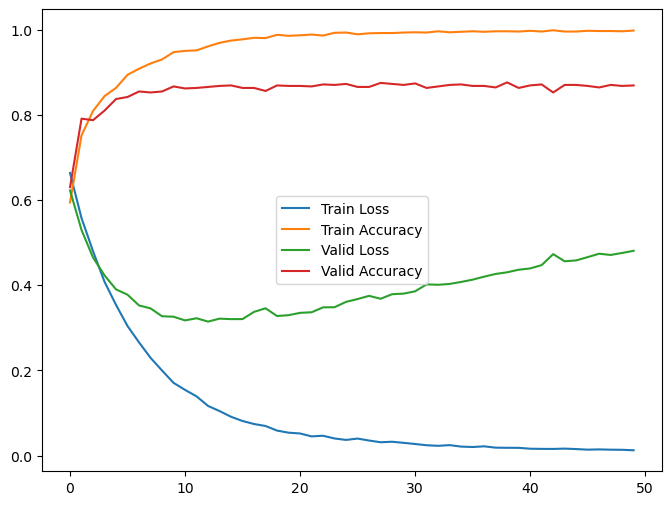

In [12]:
# 参数
num_epochs = 50
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token

data['max_len'] = 100

dropout_list = [0.,.1,.2,.3,.4,.5,.6,.7,.8,.9]
# pairs = [(16,0.5),(32,0.4),(64,0.5),(96,0.8)]

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset)
best_test_acc = 0.
for word2vec_param in word2vec_param_lst:
    for i,dropout in enumerate(dropout_list):
        model = Word2Vec_Cls(vocab_size,pad_index = train_loader.dataset.get_pad_index(),dropout=dropout,word2vec_param=word2vec_param)
        # print(model.word_embs.weight.data[:2,:])
        # 打印模型
        # print(model)
        # 损失函数 -- 交叉熵
        crit = torch.nn.NLLLoss()
        # 优化方法
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

        records = []
        best_val_acc = 0.
        for epoch in range(num_epochs):
            # 训练
            train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
            # 验证
            vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)

            # scheduler.step(vali_loss)
            # 打印消息
            # print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
            #     epoch, train_loss, train_acc, vali_loss, vali_acc))
            # 储存信息以便可视化
            records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
            best_val_acc = max(best_val_acc,vali_acc)
            if best_val_acc == vali_acc:
                    best_val_model = model

        # 测试
        _, test_acc = evaluate(best_val_model, test_loader, crit, device)
        # print(dropout,'测试集正确率：', test_acc)
        print(test_acc)
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_test_dropout = dropout
            best_word2vec_param = deepcopy(word2vec_param)
            best_model_record = deepcopy(records)
# 绘制误差曲线
plt.figure(figsize=(8,6))
plt.plot([i[0] for i in best_model_record], label = 'Train Loss')
plt.plot([i[1] for i in best_model_record], label = 'Train Accuracy')
plt.plot([i[2] for i in best_model_record], label = 'Valid Loss')
plt.plot([i[3] for i in best_model_record], label = 'Valid Accuracy')
plt.legend()

In [13]:
# 训练集、验证集一起训练
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token
dropout = best_test_dropout

data['max_len'] = 100

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset)
model_lst = []
# 模型实例化
model = Word2Vec_Cls(vocab_size,pad_index = train_loader.dataset.get_pad_index(),dropout=dropout,word2vec_param=best_word2vec_param)
crit = torch.nn.NLLLoss()
# 优化方法
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
    # 验证集也用于训练
    vali_loss, vali_acc = training(model, vali_loader, crit, optimizer,device)
    # 测试
_, test_acc = evaluate(model, test_loader, crit, device)
print('模型的测试集正确率：', test_acc)

模型的测试集正确率： 0.875886524822695


In [23]:
class K_Fold:
    def __init__(self,data,split,k=5):
        assert k>1
        train_indices = split['train']
        self.k = k
        self.train_indices,self.val_indices = self.split_train(data,train_indices,self.k)

    def __call__(self,data,model_lst):
        scores = []

        for model in model_lst:
            initial_model = deepcopy(model)
            temp_scores = []
            for i in range(self.k):
                new_split = {'train':self.train_indices[i],'vali':self.val_indices[i]}
                train_loader,vali_loader = self.get_loader(data,new_split,batch_size=64)
                model = deepcopy(initial_model)
                temp_scores.append(self.train_val(train_loader,vali_loader,model))
            scores.append(temp_scores)
        return scores

    @staticmethod    
    def split_train(data,train_indices,k):
        num_data = len(train_indices)
        random.shuffle(train_indices)
        shuffle_indices = deepcopy(train_indices).tolist()
        train_indices = []
        val_indices = []
        num_per_fold = num_data // k
        for start in range(0,num_data-num_per_fold+1,num_per_fold):
            whole_indices = deepcopy(shuffle_indices)
            val_temp = whole_indices[start:start+num_per_fold]
            for each in val_temp:
                whole_indices.remove(each)
            train_indices.append(whole_indices)
            val_indices.append(val_temp)
        return train_indices,val_indices
    

    @staticmethod
    def get_loader(data, split, batch_size=64):
        class MyDataset(Dataset): # Transformer的输入句子的表示形式会不定长，要矩阵化存储需要指定一个max_len，不到的去做padding，超过的做truncationœ
            def __init__(self, data, split):
                super().__init__()
                self.vocab = data['vocab']
                self.pad_index = len(self.vocab.keys()) if '<pad>' not in self.vocab.keys() else self.vocab['<pad>']
                self.max_len = data.get('max_len', 30)
                self.make_dataset(data, split)

            def make_dataset(self, data, split):
                # Data是包含了整个数据集的数据
                # 而我们只需要训练集/验证集/测试集的数据
                # 我们按照划分基准split里面的下标来确定加载哪部分的数据
                self.dataset = []
                for idx in split:
                    this_sentence_id = data['sentences_id'][idx]
                    item = [
                        torch.LongTensor(self.pad_data(this_sentence_id)),
                        torch.LongTensor([data['labels'][idx]])
                    ]
                    self.dataset.append(item)

            def pad_data(self, seq):
                # 让序列长度最长只有max_len，不足就补pad，超过就截断
                if len(seq) < self.max_len:
                    seq += [self.pad_index] * (self.max_len - len(seq))

                else:
                    seq = seq[:self.max_len]
                return seq
            
            def get_pad_index(self):
                return self.pad_index
                    
            def __getitem__(self, ix):
                # ix大于等于0，小于len(self.dataset)
                return self.dataset[ix]
        
            def __len__(self):
                # 一共有多少数据
                return len(self.dataset)
        # split.keys() 包括 'train', 'vali'
        # 所以此函数是为了拿到训练集，验证集的数据加载器
        loader = []
        for mode in split.keys():
            # split[mode]指定了要取data的哪些数据
            dataset = MyDataset(data, split[mode])
            # Dataloader可帮助我们一次性取batch_size个样本出来
            loader.append(
                DataLoader(dataset,
                        batch_size = batch_size,
                        shuffle = True if mode=='train' else False)
            )
        return loader

    @staticmethod
    def train_val(train_loader,vali_loader,model):
        # 参数
        num_epochs = 50
        learning_rate = 0.005
        batch_size = 128
        vocab_size = len(vocab)+1 # +1是因为<pad> token

        data['max_len'] = 100


        # 运行的设备
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')

        # 损失函数 -- 交叉熵
        crit = torch.nn.NLLLoss()
        # 优化方法
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        best_val_acc = 0.
        for epoch in range(num_epochs):
            train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
            # 验证
            vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)
            best_val_acc = max(best_val_acc,vali_acc)
        return best_val_acc

model_lst = []
for word2vec_param in word2vec_param_lst:
    model = Word2Vec_Cls(vocab_size,pad_index = train_loader.dataset.get_pad_index(),dropout=0.5,word2vec_param=word2vec_param)
    model_lst.append(model)

k_fold = K_Fold(data,split,k=5)
scores = k_fold(data,model_lst)
for score in scores:
    print(score,end='  ')
    print(f'mean score: {np.array(score).mean()}')


[0.8613569321533924, 0.8613569321533924, 0.8702064896755162, 0.8908554572271387, 0.8790560471976401]  mean score: 0.8725663716814159
[0.8643067846607669, 0.8466076696165191, 0.8731563421828908, 0.8820058997050148, 0.8672566371681416]  mean score: 0.8666666666666668
[0.8672566371681416, 0.8436578171091446, 0.8672566371681416, 0.887905604719764, 0.8761061946902655]  mean score: 0.8684365781710914
[0.8672566371681416, 0.855457227138643, 0.8731563421828908, 0.8790560471976401, 0.8849557522123894]  mean score: 0.8719764011799409


In [22]:
print(filtered_file_lst)

['sgns.merge.word', 'sgns.sogou.word', 'sgns.target.word-word.dynwin5.thr10.neg5.dim300.iter5', 'sgns.weibo.word']
